In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.integrate import solve_ivp
from math import sqrt, pi, exp, erf
from numpy import vectorize

In [2]:
%matplotlib notebook

In [3]:
# Boundaries of x0 grid
bounds_x0 = (-20, 20)

# Number of X0 grid points
Nx0 = 20

# The x0 grid interval
dx0 = (bounds_x0[1] - bounds_x0[0])/Nx0

# Boundaries of t grid
bounds_t = (0, 10)

# Initial Probability Distribution Variables
mu = 0
sigma = 1

# Constants of the experiment
h = 1
mass = 1
h2_m = h*h/mass

# Initial kinetic energy (used to determine velocity)
K0 = 1

In [4]:
kernel_size = 9
# Utility function to generate gradient matrices
def grad_matrix(forward, central, inv):
    offset = kernel_size//2
    backward = [-x if inv else x for x in reversed(forward)]
    mat = np.zeros((Nx0, Nx0), dtype = np.longdouble)
    mat[0][0:kernel_size] = forward
    mat[-1][-kernel_size:] = backward
    for i in range(1, offset):
        mat[i][i:i+kernel_size] = forward
        mat[-(i+1)][-(kernel_size+i):-i] = backward
    for i in range(offset, Nx0-(offset)):
        mat[i][i-(offset):i-offset+kernel_size] = central
    
    return mat

# Create spatial gradient operators (1st to 4th order)
derive_1 = 1/(840*dx0) * grad_matrix([-2283, 6720, -11760, 15680, -14700, 9408, -3920, 960, -105], [3, -32, 168, -672, 0, 672, -168, 32, -3], True)
derive_2 = 1/(5040*(dx0**2)) * grad_matrix([29531, -138528, 312984, -448672, 435330, -284256, 120008, -29664, 3267], [-9, 128, -1008, 8064, -14350, 8064, -1008, 128, -9], False)
derive_3 = 1/(240*(dx0**3)) * grad_matrix([-2403, 13960, -36706, 57384, -58280, 39128, -16830, 4216, -469], [-7, 72, -338, 488, 0, -488, 338, -72, 7], True)
derive_4 = 1/(240*(dx0**4)) * grad_matrix([3207, -21056, 61156, -102912, 109930, -76352, 33636, -8567, 967], [7, -96, 676, -1952, 2730, -1952, 676, -96, 7], False)

In [5]:
# Coefficient to obtain truncated Gaussian
C = 0.5 * (erf((bounds_x0[1])/(sigma*sqrt(2))) - erf((bounds_x0[0])/(sigma*sqrt(2))))

# Computes a truncated Gaussian w.r.t bounds_x0, sigma, and mu.
def gaussian(x):
    return 1/(C*sigma*sqrt(2*pi)) * exp(-0.5*((x-mu)/sigma)**2) if bounds_x0[0] <= x <= bounds_x0[1] else 0

# Computes the classical potential
def potential(x):
    return 0

# Computes the classical force (-grad(V))
def force(x):
    return 0

# Computes the initial quantum potential
def initial_quantum_potential(x):
    return -0.5 * h2_m * ratio2(x)

# Computes the initial quantum force
def initial_quantum_force(x):
    return -0.5 * h2_m  * -(x-mu)/(2*(sigma**4))

# Computes the initial acceleration for a particle at x
def initial_acceleration(x):
    return 1/mass * (force(x) + initial_quantum_force(x))

# Computes the initial R function at time t=0
def R0(x):
    return sqrt(gaussian(x))

# Computes the ratio R0'(x)/R0(x), assuming a Gaussian distribution
def ratio1(x):
    return -0.5 * (x-mu)/(sigma*sigma)

# Computes the ratio R0"(x)/R0(x), assuming a Gaussian distribution
def ratio2(x):
    return -0.5 / (sigma*sigma) * (1 - 0.5 * (((x-mu)/sigma)**2))

In [6]:
# Utility lambda to apply functions to a set of X values
_gaussian = vectorize(gaussian)
_potential = vectorize(potential)
_force = vectorize(force)
_initial_quantum_potential = vectorize(initial_quantum_potential)
_initial_quantum_force = vectorize(initial_quantum_force)
_initial_acceleration = vectorize(initial_acceleration)
_R0 = vectorize(R0)
_ratio1 = vectorize(ratio1)
_ratio2 = vectorize(ratio2)

<IPython.core.display.Javascript object>


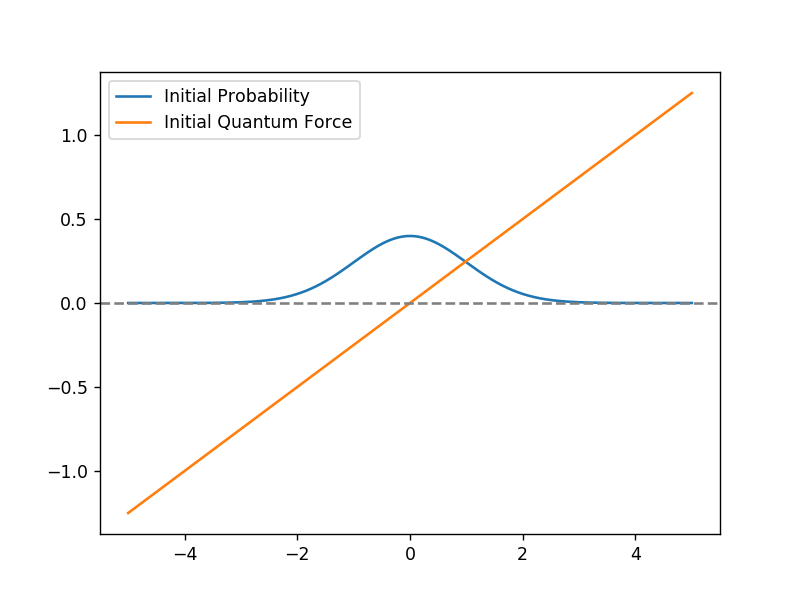

In [7]:
x_plot = np.linspace(-5, 5, 1000)
fig1 = plt.figure()
plt.plot(x_plot, _gaussian(x_plot), label="Initial Probability")
plt.plot(x_plot, _initial_quantum_force(x_plot), label="Initial Quantum Force")

plt.axhline(linestyle="--", color="gray")
plt.legend()
fig1.show()

In [8]:
def ode_derive(t, y):
    pos = y[0:Nx0]
    vel = y[Nx0:2*Nx0]
    
    if t == 0:
        return np.concatenate((vel, _initial_acceleration(pos)))
    
    der1 = derive_1 @ pos
    der2 = derive_2 @ pos
    der3 = derive_3 @ pos
    der4 = derive_4 @ pos
        
    ratio = _ratio1(pos)
    ratio_sqr = np.square(ratio)
    
    acc = 1/mass * (
                  _force(pos)
                + (der1**-4) * (der1*_initial_quantum_force(pos) 
                + 4*der2*_initial_quantum_potential(pos) 
                + h2_m * (
                      ratio_sqr*der2
                    + 3*ratio*(der2**2)/der1
                    - ratio*der3 
                    - 2.5*(der2**3)/(der1**2) 
                    + 2*der2*der3/der1 
                    - 0.25*der4)))
    
    return np.concatenate((vel, acc))

x0 = np.linspace(bounds_x0[0], bounds_x0[1], Nx0, dtype=np.longdouble)
v0 = np.full((Nx0), sqrt(2*K0/mass), dtype=np.longdouble)
y0 = np.concatenate((x0, v0))

result = solve_ivp(ode_derive, (0, 10), y0, max_step=0.01)

<IPython.core.display.Javascript object>


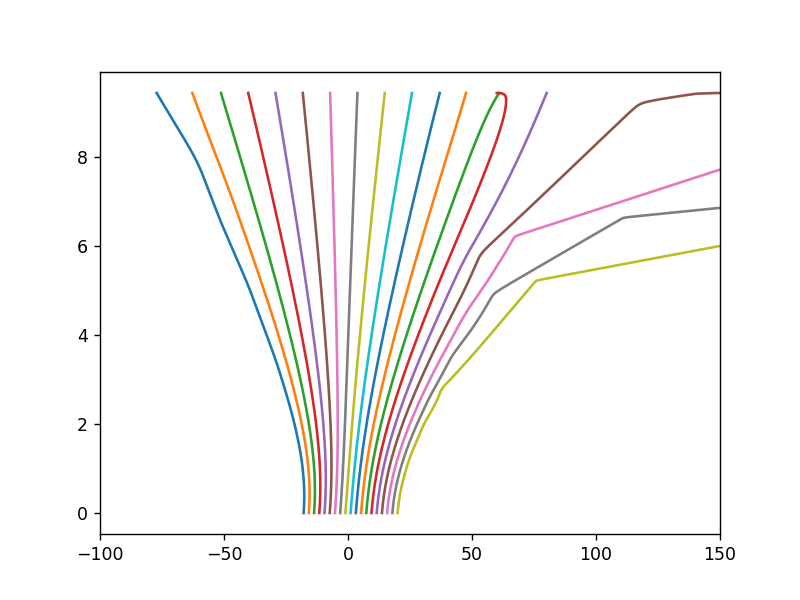

In [13]:
fig2 = plt.figure()
for i in range(1, Nx0):
    plt.plot(result.y[i], result.t)

plt.xlim(-100, 150)
fig2.show()

<IPython.core.display.Javascript object>


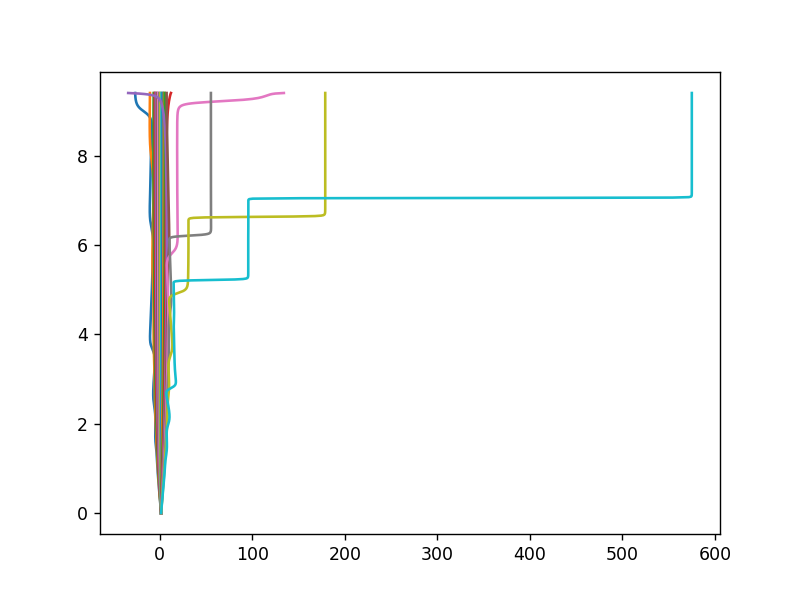

In [10]:
N=50
fig3=plt.figure()
for i in range(0, Nx0):
    plt.plot(result.y[Nx0+i][:-N], result.t[:-N])

fig3.show()

<IPython.core.display.Javascript object>


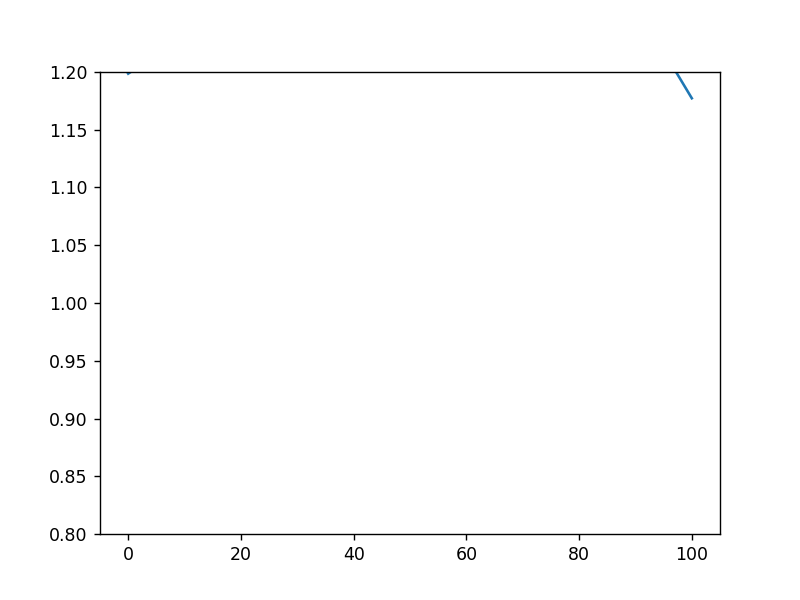

In [11]:
idx=len(result.t)-N
fig, ax = plt.subplots()
x_plot = np.linspace(0, 100, Nx0)
yt = np.transpose(result.y)
pos = yt[0][0:Nx0]
vel = yt[0][Nx0:2*Nx0]

der1 = derive_1 @ pos
der2 = derive_2 @ pos
der3 = derive_3 @ pos
der4 = derive_4 @ pos

line, = ax.plot(x_plot, derive_1 @ yt[0][0:Nx0])
plt.ylim(np.min(0.8), np.max(1.2))

def animate(i):
    d = derive_1 @ yt[i][0:Nx0]
    line.set_ydata(d)  # update the data
    return line,

def init():
    return animate(0)

ani = animation.FuncAnimation(fig, animate, np.arange(0, len(result.t)-N), init_func=init,
                              interval=100, blit=True)